<a href="https://colab.research.google.com/github/PCeltide/Python-for-Algorithmic-Trading-Cookbook/blob/main/Chapter%205/2_Finding_and_Hedging_Portfolio_Beta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openbb[all]

In [ ]:
from openbb import obb

Extensions to add: alpha_vantage@1.4.1, biztoc@1.4.2, cboe@1.4.1, deribit@1.0.1, ecb@1.4.2, econometrics@1.5.3, finra@1.4.1, finviz@1.3.1, government_us@1.4.1, multpl@1.1.1, nasdaq@1.4.1, openbb_charting@2.3.4, quantitative@1.4.3, seeking_alpha@1.4.1, stockgrid@1.4.1, technical@1.4.3, tmx@1.3.2, tradier@1.3.1, wsj@1.4.1, yfinance@1.4.6
Extensions to remove: yfinance@1.4.3

Building...


In [ ]:
obb.user.preferences.output_type = "dataframe"
obb.user.credentials.fmp_api_key = "YOUR_API_KEY"

In [ ]:
stocks = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA'] # Mag 7
market = ['SPY'] # Market Benchmark
historical_price_df = obb.equity.price.historical(symbol = stocks,
                                                  start_date = "2020-01-01",
                                                  end_date = "2025-05-17",
                                                  provider="fmp")
historical_price_SPY_df = obb.equity.price.historical(symbol = market,
                                                  start_date = "2020-01-01",
                                                  end_date = "2025-05-17",
                                                  provider="fmp")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Let's get the daily returns
# Sort by symbol and then by date for pct_change within groups
historical_price_df = historical_price_df.sort_values(by=['symbol', historical_price_df.index.name \
                                                          if historical_price_df.index.name else 'date'])
daily_returns = historical_price_df.groupby('symbol')['close'].pct_change()
# Create a DataFrame with the returns and the original symbols
returns_with_symbol = pd.DataFrame({
    'symbol': historical_price_df['symbol'],
    'daily_return': daily_returns
})
# Pivot the table to get symbols as columns and returns as values
stock_returns_df = returns_with_symbol.pivot_table(index=historical_price_df.index,
                                                  columns='symbol',
                                                  values='daily_return')
# Rename columns to match the f"{ticker_symb}_daily_return" format
stock_returns_df.columns = [f"{col}_daily_return" for col in stock_returns_df.columns]

# Drop rows where all values are NaN (which typically happens for the first day of each stock)
stock_returns_df = stock_returns_df.dropna(how='all')

In [ ]:
# Calculate daily returns directly (no grouping needed for a single symbol)
daily_market_returns = historical_price_SPY_df['close'].pct_change()

# Create the market returns DataFrame
market_returns_df = pd.DataFrame({
    f"{market[0]}_daily_return": daily_market_returns # market[0] will be 'SPY'
})
market_returns_df = market_returns_df.dropna(how='all')

# Merged if needed
combined_df = stock_returns_df.join(market_returns_df, how='inner')

In [ ]:
# Returns of Equal-Weighted Portfolio

equal_weight = np.ones(len(stocks))/len(stocks)
portfolio_returns = stock_returns_df @ equal_weight
portfolio_returns = pd.DataFrame(portfolio_returns, columns = ['portfolio_daily_return'])

In [ ]:
combined_portfolio = portfolio_returns.join(market_returns_df, how='inner')
combined_portfolio.head()

,portfolio_daily_return,SPY_daily_return
date,,
2020-01-03,-0.004512,-0.007572
2020-01-06,0.013323,0.003815
2020-01-07,0.005797,-0.002812
2020-01-08,0.013314,0.005330
2020-01-09,0.007638,0.006781


In [ ]:
import statsmodels.api as sm

In [ ]:
Y = combined_portfolio['portfolio_daily_return'] # Dependent variable
X = combined_portfolio['SPY_daily_return'] # Independent Variable
X_with_constant = sm.add_constant(X)
model = sm.OLS(Y, X_with_constant)
results = model.fit()
print(results.summary())

                              OLS Regression Results                              
Dep. Variable:     portfolio_daily_return   R-squared:                       0.732
Model:                                OLS   Adj. R-squared:                  0.732
Method:                     Least Squares   F-statistic:                     3678.
Date:                    Sun, 18 May 2025   Prob (F-statistic):               0.00
Time:                            18:36:38   Log-Likelihood:                 4164.8
No. Observations:                    1350   AIC:                            -8326.
Df Residuals:                        1348   BIC:                            -8315.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------



Calculated Alpha: 0.000785
Calculated Beta (for SYF relative to SPY): 1.339840


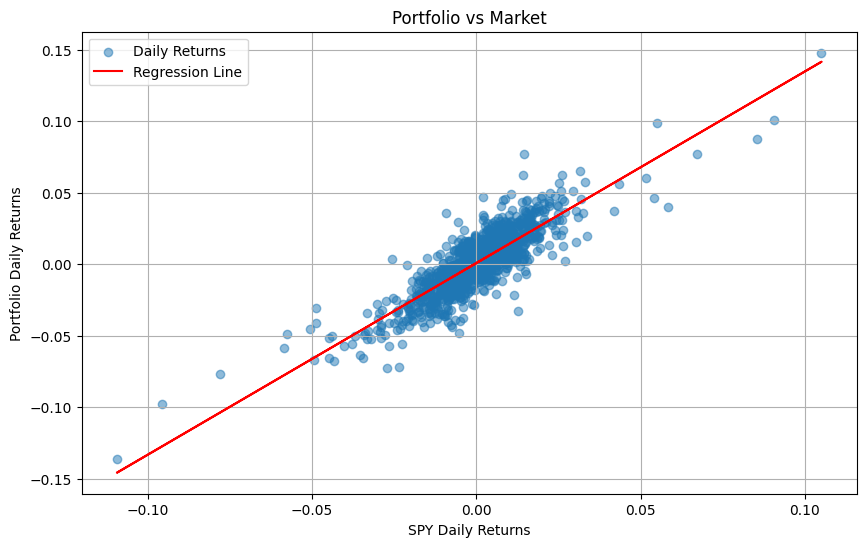

In [ ]:
alpha = results.params.get('const', float('nan'))
beta = results.params.get('SPY_daily_return', float('nan')) # Coefficient for SPY returns

print(f"\nCalculated Alpha: {alpha:.6f}")
print(f"Calculated Beta (for SYF relative to SPY): {beta:.6f}")

# Plot the regression
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, alpha=0.5, label='Daily Returns')
plt.plot(X, results.predict(X_with_constant), color='red', label='Regression Line')
plt.title('Portfolio vs Market')
plt.xlabel('SPY Daily Returns')
plt.ylabel('Portfolio Daily Returns')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Let's hedge the market with SPY

hedged_portfolio_returns = -1 * beta * X + Y # This is the beta-neutral portfolio!
hedged_portfolio_returns.name = 'hedged_portfolio_daily_return'

Y_hedged = hedged_portfolio_returns

model_hedge = sm.OLS(Y_hedged, X_with_constant)
results_hedge = model_hedge.fit()
print(results_hedge.summary())

                                  OLS Regression Results                                 
Dep. Variable:     hedged_portfolio_daily_return   R-squared:                       0.000
Model:                                       OLS   Adj. R-squared:                 -0.001
Method:                            Least Squares   F-statistic:                     0.000
Date:                           Sun, 18 May 2025   Prob (F-statistic):               1.00
Time:                                   18:36:39   Log-Likelihood:                 4164.8
No. Observations:                           1350   AIC:                            -8326.
Df Residuals:                               1348   BIC:                            -8315.
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------


Calculated Alpha: 0.000785
Calculated Beta (for SYF relative to SPY): -0.000000


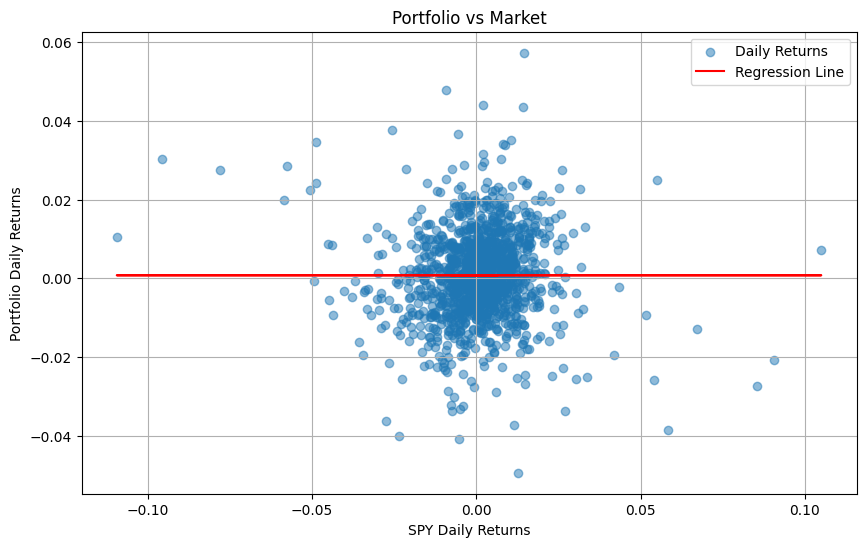

In [ ]:
alpha_hedged = results_hedge.params.get('const', float('nan'))
beta_hedged = results_hedge.params.get('SPY_daily_return', float('nan'))

print(f"\nCalculated Alpha: {alpha_hedged:.6f}")
print(f"Calculated Beta (for SYF relative to SPY): {beta_hedged:.6f}")

# Plot the regression
plt.figure(figsize=(10, 6))
plt.scatter(X, Y_hedged, alpha=0.5, label='Daily Returns')
plt.plot(X, results_hedge.predict(X_with_constant), color='red', label='Regression Line')
plt.title('Portfolio vs Market')
plt.xlabel('SPY Daily Returns')
plt.ylabel('Portfolio Daily Returns')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# We define the information ratio as follows:

A = combined_portfolio['portfolio_daily_return']
B = combined_portfolio['SPY_daily_return']

active_return_unhedged = A - B # Excess return
active_return_unhedged.name = 'active_return_unhedged'

tracking_error_unhedged = active_return_unhedged.std()
ir_unhedged = active_return_unhedged.mean() / tracking_error_unhedged
# Measures how well your original portfolio beats SPY, considering the volatility of that difference

tracking_error_hedged = hedged_portfolio_returns.std()
appraisal_ratio = hedged_portfolio_returns.mean() / tracking_error_hedged
# The above measures the return of your market-neutral alpha strategy per unit of its own risk

In [ ]:
print(f"The Information Ratio for an unhedged portfolio is: {ir_unhedged}")
print(f"The Appraisal Ratio for an hedged portfolio is: {appraisal_ratio}")

print(f"\nThe volatility of the excess return of the unhedged portfolio is: {active_return_unhedged.std()}")
print(f"The volatility of the hedged portfolio is: {hedged_portfolio_returns.std()}")

The Information Ratio for an unhedged portfolio is: 0.08069807542084352
The Appraisal Ratio for an hedged portfolio is: 0.07089412715380543

The volatility of the excess return of the unhedged portfolio is: 0.012001678607404441
The volatility of the hedged portfolio is: 0.011069301612453479


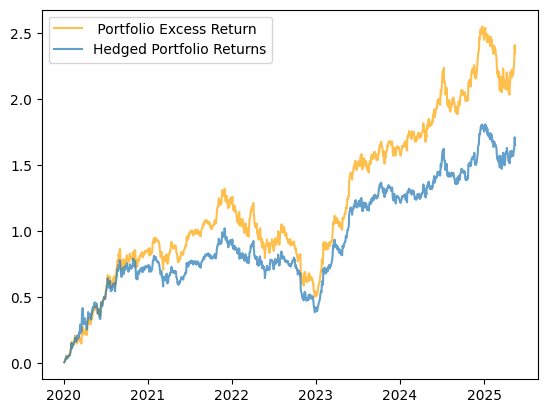

In [ ]:
# Let us try to understand why the Information Ratio of the unhedged portfolio
# is higher the Appraisal Ratio for the hedged portfolio, but has a similar vol

# Let's plot the two times series and compare

cumulative_hedged_returns = (1 + hedged_portfolio_returns).cumprod() - 1
cumulative_active_returns = (1 + active_return_unhedged).cumprod() - 1

#plt.plot(hedged_portfolio_returns.index, hedged_portfolio_returns.cumsum(), label = 'Hedged Portfolio Returns', alpha = 0.7)
plt.plot(cumulative_active_returns.index, cumulative_active_returns, color = 'orange', label = ' Portfolio Excess Return', alpha = 0.7)
plt.plot(cumulative_hedged_returns.index, cumulative_hedged_returns, label = 'Hedged Portfolio Returns', alpha = 0.7)
plt.legend()
plt.show()

The volatilities are similar because this "extra" market-related risk component in `active_return_unhedged` isn't overwhelmingly large compared to the stock-specific (idiosyncratic) risk that is common to both calculations when we break them down this way!